---
title: "How WEIRD is FAccT?"
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.dpi'] = 150

In [3]:
plt.rcParams['font.family'] = ['Linux Libertine O']

# Loading Data & Metrics

In [4]:
df = pd.read_csv('datasets/weird_faccts.csv')
df['paper_id'] = df['paper_id'].ffill()
df['publication_year'] = df['publication_year'].ffill()
df['non_human'] = df['non_human'].notna()
df['synthetic'] = df['synthetic'].notna()
df = df.drop(['paper_title', 'url', 'url_data', 'notes'], axis=1)
df = df.replace('y', True).replace('n', False)
df.head()

,paper_id,publication_year,nb_records,dataset,country,non_human,synthetic,unclear,email,sent,replied,original
0,1.0,2018.0,10000.0,North Carolina voter,USA,False,False,NaN,NaN,NaN,NaN,NaN
1,5.0,2018.0,6172.0,COMPAS recidivism,USA,False,False,NaN,NaN,NaN,NaN,NaN
2,5.0,2019.0,6114.0,Dark Reactions,NaN,True,False,NaN,NaN,NaN,NaN,NaN
3,7.0,2018.0,437.0,Pilot Parliaments Benchmark,ZAF,False,False,NaN,NaN,NaN,NaN,NaN
4,7.0,2018.0,149.0,Pilot Parliaments Benchmark,SEN,False,False,NaN,NaN,NaN,NaN,NaN


In [5]:
df['paper_id'].nunique()

225

In [6]:
edu = pd.read_csv('datasets/edu.csv')
gdp = pd.read_csv('datasets/gdp.csv')
gni = pd.read_csv('datasets/gni.csv')
western = pd.read_csv('datasets/western.csv')
population = pd.read_csv('datasets/population.csv').query('Time == 2020')

/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_8617/586684894.py:5: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  population = pd.read_csv('datasets/population.csv').query('Time == 2020')


In [11]:
from bs4 import BeautifulSoup
import requests

# Collecting democratic index
resp = requests.get("https://freedomhouse.org/countries/freedom-world/scores")

soup = BeautifulSoup(resp.text, 'html.parser')
rows = soup.tbody.find_all('tr')

democratic = pd.DataFrame(
    [[el.text for el in row.find_all('td')] for row in rows],
    columns=['country_name', 'total_score', 'political rights', 'civil liberties']
)
democratic['country_name'] = (
    democratic.country_name
    .replace('United States', 'United States of America')
    .replace('Iran', 'Iran (Islamic Republic of)')
    .replace('South Korea', 'Republic of Korea')
    .replace('Russia', 'Russian Federation')
)
democratic['political rights'] = democratic['political rights'].astype('float')

In [12]:
TOTAL_POPULATION = population[population['ISO3_code'].notna()]['PopTotal'].sum()

# Preliminary Analysis

In [13]:
# Filtering papers based on exclusion criteria
data = df.query('~non_human and ~synthetic and nb_records.notna() and country.notna()').copy()
data['nb_participants'] = data['nb_records'].astype('float')
data['original'] = data['original'].fillna(False)

In [15]:
print(f"Number of analyzed papers: {data['paper_id'].nunique()}")

Number of analyzed papers: 128


In [21]:
def combine(df):
    return pd.merge(
        df,
        population.dropna(subset='ISO3_code')[['ISO3_code', 'Location', 'PopTotal']],
        how='left',
        left_on='country',
        right_on='ISO3_code',
    ).merge(
        gdp.assign(country=gdp['Country Code'], gdp=gdp['2020'])[['country', 'gdp']],
        how='left',
        on='country',
    ).merge(
        gni.assign(country=gni['Country Code'], gni=gni['2020'])[['country', 'gni']],
        how='left',
        on='country',
    ).merge(
        western,
        how='left',
        on='country',
    ).merge(
        edu,
        how='left',
        left_on='Location',
        right_on='country_name',
    ).merge(
        democratic,
        how='left',
        on='country_name'
    )

def get_stats(data):
    stats = data.groupby('country').agg({
        'nb_participants': 'sum',
        'paper_id': pd.Series.nunique
    }).rename({'paper_id': 'nb_papers'}, axis=1)

    stats['participants_pct'] = stats['nb_participants'] / stats['nb_participants'].sum()
    stats['papers_pct'] = stats['nb_papers'] / stats['nb_papers'].sum()

    stats = combine(stats.reset_index())
    stats['population_pct'] = stats['PopTotal'] / TOTAL_POPULATION
    stats['psi_p'] = stats['participants_pct'] / stats['population_pct']
    stats['psi_s'] = stats['papers_pct'] / stats['population_pct']

    stats['educated'] = stats['mean_edu'].gt(stats['mean_edu'].median())
    stats['industrialized'] = stats['gdp'].gt(stats['gdp'].median())
    stats['rich'] = stats['gni'].gt(stats['gni'].median())
    stats['democratic'] = stats['political rights'].gt(stats['political rights'].median())
    return stats

In [22]:
# Getting base table for the analysis, contains info for Table 2
stats = get_stats(data)

In [31]:
(
    stats
    .sort_values('psi_p', ascending=False)
    .filter(['Location', 'nb_participants', 'participants_pct', 'psi_p'])
    .head(10)
    .set_index('Location')
    .style.format({
        'nb_participants': '{:,.0f}',
        'participants_pct': '{:.2%}',
        'psi_p': '{:.2f}'
    })
)

,nb_participants,participants_pct,psi_p
Location,,,
United States of America,"16,621,168",93.62%,21.85
Colombia,"472,000",2.66%,4.09
Portugal,"87,963",0.50%,3.77
"China, Taiwan Province of China","120,000",0.68%,2.22
Costa Rica,"22,000",0.12%,1.90
India,"399,528",2.25%,0.13
Germany,"15,750",0.09%,0.08
Iceland,63,0.00%,0.08
Slovenia,336,0.00%,0.07


In [30]:
(
    stats
    .sort_values('psi_s', ascending=False)
    .filter(['Location', 'nb_papers', 'papers_pct', 'psi_s'])
    .head(10)
    .set_index('Location')
    .style.format({
        'nb_papers': '{:,.0f}',
        'papers_pct': '{:.2%}',
        'psi_s': '{:.2f}'
    })
)

,nb_papers,papers_pct,psi_s
Location,,,
Iceland,1,0.44%,93.79
Guyana,1,0.44%,43.14
Ireland,4,1.75%,27.81
Cyprus,1,0.44%,27.79
Portugal,7,3.07%,23.38
Trinidad and Tobago,1,0.44%,22.65
New Zealand,3,1.32%,20.38
Slovenia,1,0.44%,16.24
Sweden,4,1.75%,13.27


In [29]:
(
    stats
    .sort_values('papers_pct', ascending=False)
    .filter(['Location', 'nb_papers', 'papers_pct', 'psi_s'])
    .head(10)
    .set_index('Location')
    .style.format({
        'nb_papers': '{:,.0f}',
        'papers_pct': '{:.2%}',
        'psi_s': '{:.2f}'
    })
)

,nb_papers,papers_pct,psi_s
Location,,,
United States of America,106,46.49%,10.85
Germany,20,8.77%,8.25
United Kingdom,12,5.26%,6.15
India,8,3.51%,0.20
Portugal,7,3.07%,23.38
"China, Taiwan Province of China",4,1.75%,5.77
Canada,4,1.75%,3.63
Sweden,4,1.75%,13.27
Ireland,4,1.75%,27.81


## Frequently Used Off-the-Shelf Datasets

In [32]:
df.assign(original=df['original'].fillna(False)).query('not original and not synthetic')[['paper_id', 'dataset']].drop_duplicates().dataset.value_counts().head(10)

Adult                 23
COMPAS recidivism     21
German                13
MNIST                  5
Large Movie Review     5
ACS                    5
MIMIC-III              4
FairFace               4
Law (LSAC)             4
ML1M                   4
Name: dataset, dtype: int64

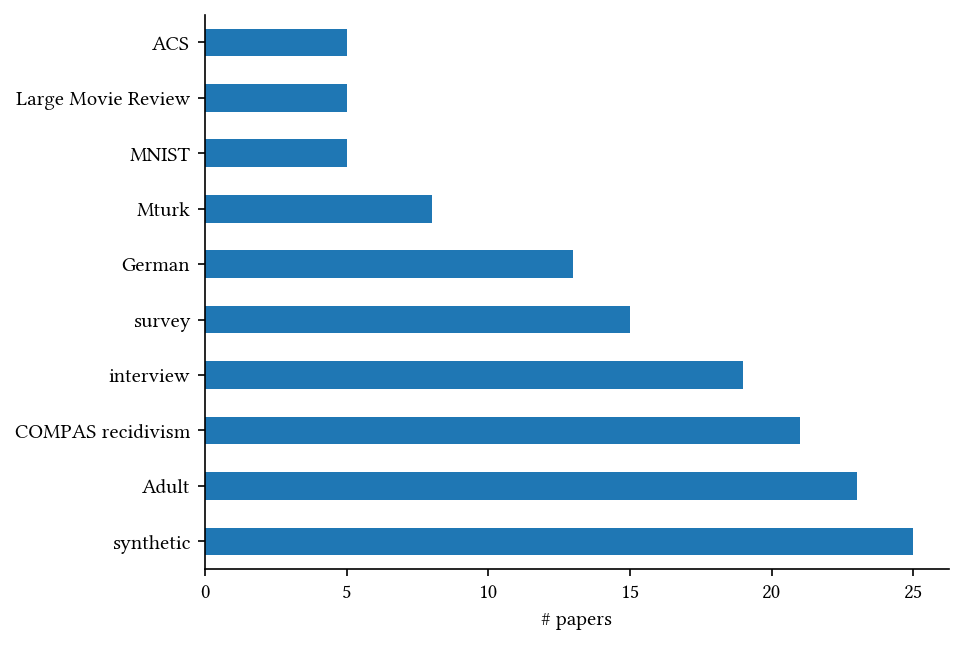

In [38]:
df[['paper_id', 'dataset']].drop_duplicates().dataset.value_counts().head(10).plot.barh()
plt.xlabel('# papers')
plt.savefig('figures/dataset.pdf', bbox_inches='tight', facecolor='w')

In [39]:
data.pivot_table(
    index='dataset',
    columns='country',
    values='nb_participants',
    aggfunc='max'
)['USA'].sort_values(ascending=False).dropna().head(10).reset_index()

,dataset,USA
0,HMDA,3930315.0
1,ACSIncome,1664500.0
2,ACS13,1494974.0
3,Lending Club,1373324.0
4,Operational Audits 2014,791900.0
5,ACS,636625.0
6,Lending Club (Kaggle),626000.0
7,Funding,612262.0
8,North Carolina voter,539607.0
9,PredPol,447871.0


## Drawing Teaser Figure

In [40]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [41]:
plt.rcParams['font.size'] = 8

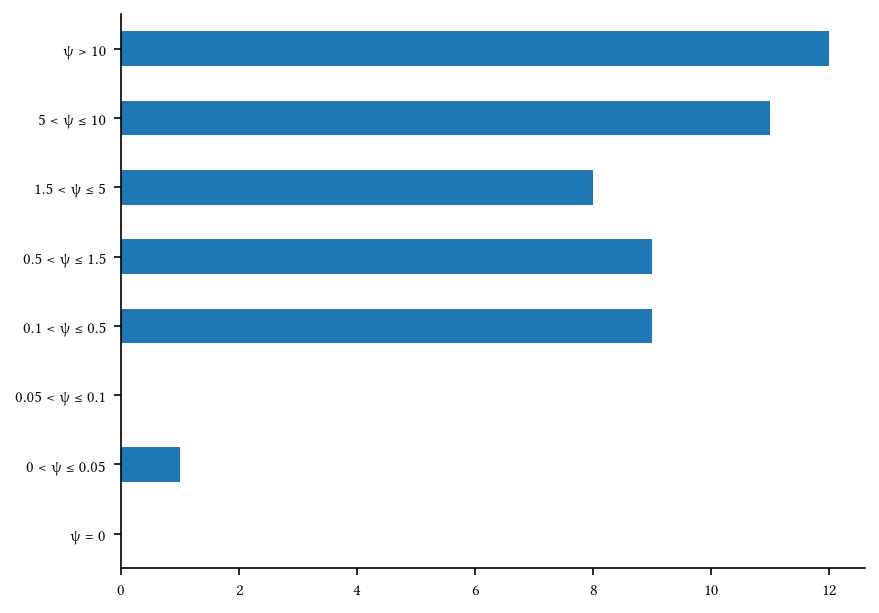

In [42]:
stats['psi_s_cut'] = pd.cut(
    stats['psi_s'],
    [-np.inf, 0, 0.05, 0.1, 0.5, 1.5, 5, 10, np.inf],
    labels=['ψ = 0', '0 < ψ ≤ 0.05', '0.05 < ψ ≤ 0.1', '0.1 < ψ ≤ 0.5', '0.5 < ψ ≤ 1.5', '1.5 < ψ ≤ 5', '5 < ψ ≤ 10', 'ψ > 10']
)
stats['psi_s_cut'].value_counts().sort_index().plot.barh();

In [43]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#ffffff'] + ['#d73027','#fc8d59','#fee090','#fff4bd','#e0f3f8','#91bfdb','#4575b4'][::-1])

For the following map, $\psi > 1.5$ means over-represented, $\psi < 0.5$ means under-represented

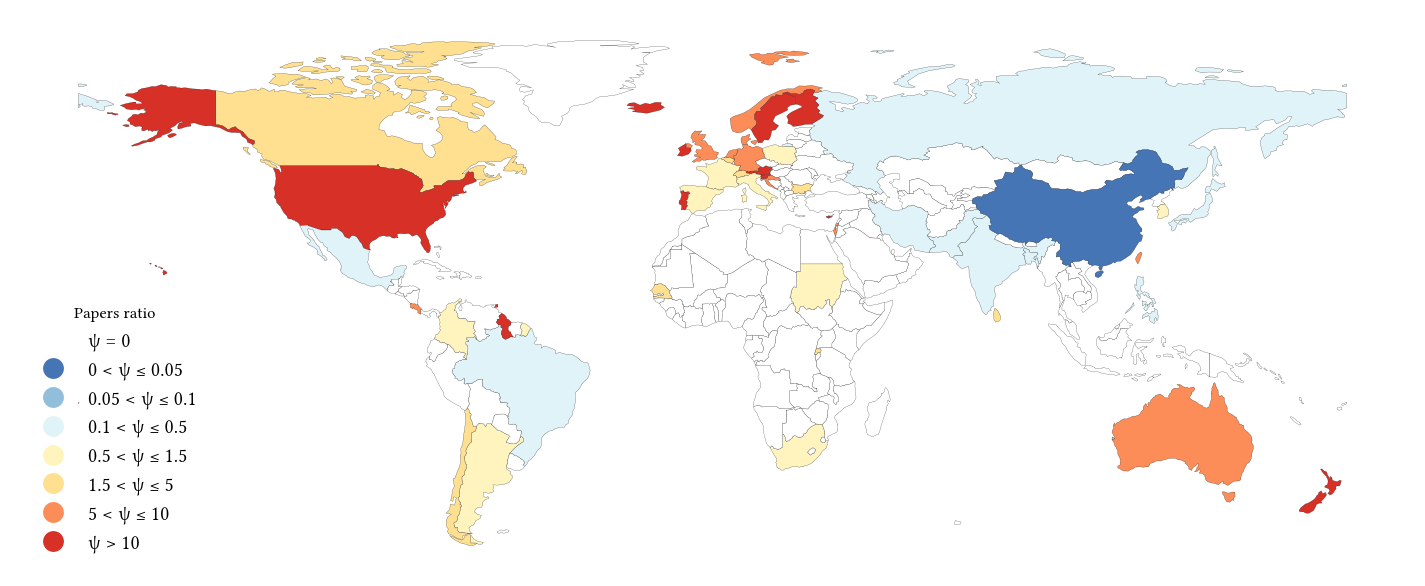

In [45]:
ax = world.query('continent != "Antarctica"').merge(
    stats,
    how='left',
    left_on='iso_a3',
    right_on='country'
).fillna('ψ = 0').plot(
    column='psi_s_cut', edgecolor='black',
    linewidth=0.1, figsize=(12, 7),
    legend=True,
    legend_kwds=dict(
        title='Papers ratio',
        loc='lower left',
        frameon=False,
        fontsize=9.5
    ),
    cmap=cmap
)
plt.axis('off')
plt.savefig('figures/world-map.pdf', dpi=150, bbox_inches='tight')

## Number of Paper per Year

In [68]:
chi_year = pd.read_csv('datasets/chi_year.tsv', sep='\t')
chi_country = pd.read_csv('datasets/chi_country.tsv', sep='\t')
chi_data = pd.merge(
    chi_country,
    chi_year,
    how='left',
    on='paper_id'
).rename({'country_code': 'country'}, axis=1)

In [69]:
facct_year = pd.read_csv('datasets/facct_year.tsv', sep='\t')

In [70]:
chi_year.groupby('publication_year').paper_id.nunique()

publication_year
2016    544
2017    600
2018    666
2019    701
2020    758
Name: paper_id, dtype: int64

In [71]:
facct_year.groupby('publication_year').paper_id.nunique()

publication_year
2018     17
2019     41
2020     95
2021     82
2022    181
Name: paper_id, dtype: int64

In [72]:
pct_analyzed = (data.groupby('publication_year').paper_id.nunique() / facct_year.groupby('publication_year').paper_id.nunique())
pct_analyzed.index = pct_analyzed.index.astype(int)

In [73]:
facct_year['is_analyzed'] = facct_year['paper_id'].isin(data.paper_id.unique())

In [74]:
facct_year.groupby('publication_year').paper_id.size()

publication_year
2018     17
2019     41
2020     95
2021     82
2022    181
Name: paper_id, dtype: int64

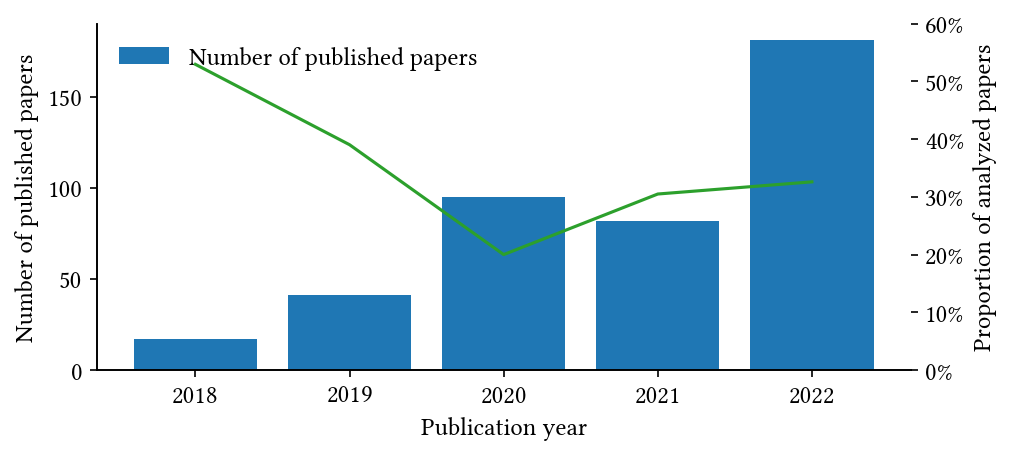

In [76]:
import matplotlib.ticker as mtick

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(7, 3))
axx = ax.twinx()
ax.bar(range(2018, 2023), facct_year.groupby('publication_year').paper_id.size(), color='#1f77b4');
(pct_analyzed * 100).plot.line(color='C2', ax=axx)
axx.set_ylim(0, 60)
axx.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Number of published papers')
ax.set_xlabel('Publication year')
axx.set_ylabel('Proportion of analyzed papers')
ax.legend(['Number of published papers', 'proportion of analyzed papers'], frameon=False)
plt.savefig('figures/nb_papers.pdf', bbox_inches='tight', facecolor='w')

# RQ1: How WEIRD is the FAccT conference?

In [78]:
from scipy.stats import kendalltau

def compute_metric(stats, x1, x2, bootstrap=False, is_print=True):
    variables = stats[[x1, x2]].dropna()
    if bootstrap:
        tau = [kendalltau(*variables.sample(len(variables), replace=True).values.T)[0] for _ in range(10_000)]
        mu = np.array(tau).mean()
        sigma = 2 * np.array(tau).std()
        if is_print:
            print(f"{mu:.2f};[{mu - sigma:.3f}, {mu + sigma:.3f}]")
        else:
            return np.array(tau)
    else:
        tau, p_value = kendalltau(*variables.values.T)
        if is_print:
            print(f"tau = {tau:.2f}, p-val = {p_value:.4f}")
        else:
            return tau, p_value

In [80]:
# This is a sandbox to see how Kendall tau rank correlation works.
# Try to change the value of a and b and see what happens to the correlation.
from scipy.stats import spearmanr, kendalltau

z = pd.DataFrame({
    "country": ["USA", "GBR", "DEU", "JPN"],
    "a": [4, 3, 1, 2],
    "b": [4, 3, 2, 1]
})
print(z)
print(kendalltau(z['a'], z['b']))
print(spearmanr(z['a'], z['b']))

  country  a  b
0     USA  4  4
1     GBR  3  3
2     DEU  1  2
3     JPN  2  1
KendalltauResult(correlation=0.6666666666666669, pvalue=0.3333333333333333)
SpearmanrResult(correlation=0.7999999999999999, pvalue=0.20000000000000007)


In [108]:
# Western
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
combine(data).groupby('paper_id').west.mean().value_counts()

1.000000    108
0.000000      9
0.500000      7
0.769231      1
0.527778      1
0.666667      1
0.750000      1
Name: west, dtype: int64

In [109]:
# Computing EIRD
compute_metric(stats, 'mean_edu', 'psi_s')
compute_metric(stats, 'gdp', 'psi_s')
compute_metric(stats, 'gni', 'psi_s')
compute_metric(stats, 'political rights', 'psi_s')

tau = 0.31, p-val = 0.0016
tau = 0.35, p-val = 0.0004
tau = 0.34, p-val = 0.0005
tau = 0.37, p-val = 0.0003


# RQ2: How FAccT and CHI conferences compare in terms of WEIRD-ness?

In [46]:
chi = pd.read_csv('datasets/chi.tsv', sep='\t')
chi_stats = pd.merge(
    pd.read_csv('datasets/chi_psi_p.csv'),
    pd.read_csv('datasets/chi_psi_s.csv'),
    how='left',
    on='country'
)
chi_stats = combine(chi_stats)
chi_stats['participants_pct'] = chi_stats['nb_participants'] / chi_stats['nb_participants'].sum()
chi_stats['population_pct'] = chi_stats['PopTotal'] / TOTAL_POPULATION
chi_stats['papers_pct'] = chi_stats['nb_study'] / chi_stats['nb_study'].sum()
# Recalculate psi_p and psi_s because of the population differences
chi_stats['psi_p'] = chi_stats['participants_pct'] / chi_stats['population_pct']
chi_stats['psi_s'] = chi_stats['papers_pct'] / chi_stats['population_pct']

In [52]:
chi_stats.sort_values('nb_study', ascending=False).head(10)[['country', 'nb_participants', 'pct_participants', 'psi_p', 'nb_study', 'pct_study', 'psi_s']]

,country,nb_participants,pct_participants,psi_p,nb_study,pct_study,psi_s
0,USA,136834,54.84,12.799916,493,45.82,7.635513
7,GBR,7829,3.14,3.668796,169,15.71,13.112399
18,DEU,4697,1.88,1.771340,94,8.74,5.869314
4,CAN,6367,2.55,5.280834,82,7.62,11.260552
42,CHN,8397,3.37,0.185186,64,5.95,0.233691
34,IND,20132,8.07,0.453063,57,5.30,0.212385
8,AUS,2544,1.02,3.114353,53,4.93,10.742484
14,KOR,3429,1.37,2.078455,44,4.09,4.415745
22,FRA,3012,1.21,1.467936,29,2.70,2.340067
30,JPN,2492,1.00,0.625268,29,2.70,1.204742


## Validating the Difference in Countries between FAccT and CHI (Supplementary)

In [53]:
country_intersection = set(chi_stats.country).intersection(set(stats.country))

In [54]:
chi_same = chi_stats.query('country in @country_intersection').copy()
facct_same = stats.query('country in @country_intersection').copy()
chi_same['psi_s'] = (chi_same['nb_study'] / chi_same['nb_study'].sum()) / (chi_same['PopTotal'] / chi_same['PopTotal'].sum())
facct_same['psi_s'] = (facct_same['nb_papers'] / facct_same['nb_papers'].sum()) / (facct_same['PopTotal'] / facct_same['PopTotal'].sum())
chi_same['psi_p'] = (chi_same['nb_participants'] / chi_same['nb_participants'].sum()) / (chi_same['PopTotal'] / chi_same['PopTotal'].sum())
facct_same['psi_p'] = (facct_same['nb_participants'] / facct_same['nb_participants'].sum()) / (facct_same['PopTotal'] / facct_same['PopTotal'].sum())

In [55]:
country_diff = set(chi_stats['country']) - set(stats['country'])
print(f"Different countries: {len(country_diff)}")
western.query('country in @country_diff').west.value_counts()

Different countries: 50


0    43
1     7
Name: west, dtype: int64

In [58]:
print(f"Number of overlapping countries: {chi_stats.query('country in @country_diff').nb_study.sum()}")

Number of overlapping countries: 108


In [61]:
c = pd.read_csv('datasets/chi_country.tsv', sep='\t')
c['new_id'] = c['paper_id'].astype('category').cat.codes

## Affiliations

In [110]:
affiliations = pd.read_csv('datasets/affiliations.tsv', sep='\t')
affiliations['paper_id'] = affiliations['DOI'].map(
    dict(zip(affiliations['DOI'].unique(), np.arange(18, 417)))
)

In [112]:
affil_2018 = pd.read_csv('datasets/affil_2018.tsv', sep='\t')
paper_2018 = pd.read_csv('datasets/paper_2018.csv')
affil_2018['title'] = affil_2018['title'].str.strip()

In [113]:
a = pd.merge(
    affil_2018,
    paper_2018,
    how='left',
    on='title'
)

In [114]:
analysed_paper_id = data['paper_id'].unique()
pd.concat([
    a[['paper_id', 'affiliation']],
    affiliations[['paper_id', 'affiliation']]
]).query('paper_id in @analysed_paper_id').head()

,paper_id,affiliation
6,7,MIT
7,7,Microsoft
8,17,DePaul University
9,17,DePaul University
10,17,DePaul University


In [115]:
# Preprocessing 2018
a = a.groupby('paper_id').agg({
    'affiliation': [pd.Series.nunique, 'size']
}).reset_index()
a.columns = ['paper_id', 'nb_affils', 'nb_authors']

# Preprocessing 2019-2022
aff = affiliations.groupby('DOI').agg({
    'affiliation': [pd.Series.nunique, 'size']
})
aff.index = np.arange(18, 417)
aff = aff.reset_index()
aff.columns = ['paper_id', 'nb_affils', 'nb_authors']

# Combining the two
aff = pd.concat([a, aff])

In [116]:
facct_countries = pd.read_csv('datasets/facct_countries.csv')

In [119]:
# Western by Author Affiliation
pd.merge(
    facct_countries,
    western,
    how='left',
    on='country'
).groupby('paper_id').west.mean().value_counts()

1.000000    112
0.000000      4
0.666667      3
0.750000      2
0.600000      2
0.777778      1
0.833333      1
0.500000      1
0.333333      1
0.875000      1
Name: west, dtype: int64

In [120]:
pd.merge(
    facct_countries,
    western,
    how='left',
    on='country'
)[['country', 'west']].drop_duplicates().dropna().sort_values('west').west.value_counts(True)

1.0    0.65
0.0    0.35
Name: west, dtype: float64

In [121]:
aff = pd.merge(
    facct_countries,
    western,
    how='left',
    on='country'
).groupby('paper_id').agg({
    'affiliation': ['size', pd.Series.nunique],
    'country': pd.Series.nunique,
    'west': 'mean'
}).reset_index()
aff.columns = ['paper_id', 'nb_authors', 'nb_affils', 'nb_countries', 'western']

In [122]:
aff_facct = pd.merge(
    combine(data.dropna(subset='country')).groupby('paper_id').agg({
        'mean_edu': 'mean',
        'gdp': 'mean',
        'gni': 'mean',
        'political rights': 'mean'
    }),
    aff,
    how='left',
    left_index=True,
    right_on='paper_id'
)
aff_facct = aff_facct.rename({'political rights': 'pol_rights'}, axis=1)

In [123]:
aff_facct.head()

,mean_edu,gdp,gni,pol_rights,paper_id,nb_authors,nb_affils,nb_countries,western
0,13.700000,63027.679527,64210.000000,33.000000,1,9,5,4,0.777778
1,13.700000,63027.679527,64210.000000,33.000000,5,3,2,1,1.000000
2,9.666667,29782.563070,29926.666667,31.166667,7,2,2,1,1.000000
3,6.700000,6525.428052,6440.000000,33.000000,8,7,4,1,0.000000
4,13.700000,63027.679527,64210.000000,33.000000,12,5,3,2,1.000000


In [125]:
chi_affil = pd.read_csv('datasets/chi_affil.tsv', sep='\t')
chi_aff = chi_affil.groupby('paper_id').agg({
    'country': [pd.Series.nunique, 'size']
}).reset_index()
chi_aff.columns = ['paper_id', 'nb_countries', 'nb_authors']

In [126]:
aff_chi = combine(c).groupby('paper_id').agg({
    'mean_edu': 'mean',
    'gdp': 'mean',
    'gni': 'mean',
    'political rights': 'mean'
}).reset_index().merge(
    chi_aff,
    how='left',
    on='paper_id'
)
aff_chi = aff_chi.rename({'political rights': 'pol_rights'}, axis=1)

In [127]:
aff_chi['multiple_authors'] = aff_chi['nb_authors'].gt(1)
aff_chi['multiple_countries'] = aff_chi['nb_countries'].gt(1)

In [129]:
# Number of papers with authors from multiple countries
aff_chi['multiple_countries'].value_counts()

False    826
True     250
Name: multiple_countries, dtype: int64

In [58]:
# Generating Table 7 - CHI
np.random.seed(42)

corrs = []
for _ in range(10_000):
    corrs.append(aff_chi[['mean_edu', 'gdp', 'gni', 'pol_rights', 'nb_countries']].sample(1076, replace=True).corr().nb_countries.values[:-1])
corrs = np.array(corrs)

In [59]:
print(
    pd.DataFrame(
        np.concatenate([
            [corrs.mean(axis=0)],
            np.quantile(corrs, [0.025, 0.975], axis=0)
        ]).T,
        index=['Educated', 'Industrialized', 'Rich', 'Democratic']
    ).style.format('{:.2f}').to_latex()
)

\begin{tabular}{lrrr}
 & 0 & 1 & 2 \\
Educated & -0.22 & -0.30 & -0.15 \\
Industrialized & -0.21 & -0.29 & -0.14 \\
Rich & -0.23 & -0.30 & -0.16 \\
Democratic & -0.10 & -0.18 & -0.03 \\
\end{tabular}



In [133]:
aff_facct['nb_countries'].value_counts(True)

1    0.750000
2    0.218750
3    0.023438
4    0.007812
Name: nb_countries, dtype: float64

In [134]:
aff_facct['multiple_authors'] = aff_facct['nb_authors'].gt(1)
aff_facct['multiple_countries'] = aff_facct['nb_countries'].gt(1)

In [135]:
aff_facct.groupby('multiple_authors').agg({
    'mean_edu': ['mean', 'std'],
    'gdp': ['mean', 'std'],
    'gni': ['mean', 'std'],
    'pol_rights': ['mean', 'std'],
}).style.format('{:,.2f}')

In [136]:
aff_facct['nb_countries'].mean(), aff_facct['nb_countries'].std()

(1.2890625, 0.5491918722982208)

In [137]:
aff_facct['nb_authors'].mean(), aff_facct['nb_authors'].std()

(4.0546875, 2.8431672306733566)

In [66]:
# Generating Table 7 - FAccT

corrs = []
for _ in range(10_000):
    corrs.append(aff_facct[['mean_edu', 'gdp', 'gni', 'pol_rights', 'nb_countries']].sample(128, replace=True).corr().nb_countries.values[:-1])
corrs = np.array(corrs)

In [67]:
print(
    pd.DataFrame(
        np.concatenate([
            [corrs.mean(axis=0)],
            np.quantile(corrs, [0.025, 0.975], axis=0)
        ]).T,
        index=['Educated', 'Industrialized', 'Rich', 'Democratic']
    ).style.format('{:.2f}').to_latex()
)

\begin{tabular}{lrrr}
 & 0 & 1 & 2 \\
Educated & -0.06 & -0.24 & 0.10 \\
Industrialized & -0.07 & -0.25 & 0.10 \\
Rich & -0.07 & -0.25 & 0.10 \\
Democratic & 0.03 & -0.13 & 0.20 \\
\end{tabular}



## Multiple Countries

### FAccT

In [138]:
aff_facct.groupby('multiple_countries').size()

multiple_countries
False    96
True     32
dtype: int64

In [139]:
for multiple_countries, group in data.merge(
    aff_facct[['paper_id', 'multiple_authors', 'multiple_countries']],
    how='left',
    on='paper_id'
).groupby('multiple_countries'):
    print(f"=== Multiple Countries: {multiple_countries} ===")
    print(group.shape)
    print(f"Western sampled countries = {get_stats(group).west.mean():.2%}")
    for col in ['mean_edu', 'gdp', 'gni', 'political rights']:
        compute_metric(get_stats(group), col, 'psi_s', is_print=True)

=== Multiple Countries: False ===
(215, 15)
Western sampled countries = 50.00%
tau = 0.31, p-val = 0.0024
tau = 0.34, p-val = 0.0010
tau = 0.34, p-val = 0.0012
tau = 0.37, p-val = 0.0005
=== Multiple Countries: True ===
(51, 15)
Western sampled countries = 66.67%
tau = -0.11, p-val = 0.5835
tau = 0.25, p-val = 0.2331
tau = 0.21, p-val = 0.3308
tau = 0.08, p-val = 0.6920


In [140]:
paper_ids = data.paper_id.unique()
nb_multiple_countries = aff_facct['multiple_countries'].sum()

In [141]:
data_with_aff = data.merge(
    aff_facct[['paper_id', 'multiple_authors', 'multiple_countries']],
    how='left',
    on='paper_id'
)

In [142]:
combine(data_with_aff.query('multiple_countries')).groupby('paper_id').west.mean().value_counts()

1.0    26
0.0     4
0.5     2
Name: west, dtype: int64

In [143]:
combine(data_with_aff.query('~multiple_countries')).groupby('paper_id').west.mean().value_counts()

1.000000    82
0.500000     5
0.000000     5
0.769231     1
0.527778     1
0.666667     1
0.750000     1
Name: west, dtype: int64

In [ ]:
# Generating Table 8
np.random.seed(42)

for col in [
    'mean_edu',
    'gdp',
    'gni',
    'political rights'
]:
    tau_diff = []
    for _ in range(10_000):
        ori_ids = np.random.choice(paper_ids, nb_multiple_countries)

        tau_multiple = compute_metric(get_stats(data_with_aff.query('paper_id in @ori_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_single = compute_metric(get_stats(data_with_aff.query('paper_id not in @ori_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_diff.append(tau_single - tau_multiple)

    tau_multiple = compute_metric(get_stats(data_with_aff.query('multiple_countries')), col, 'psi_s', bootstrap=False, is_print=False)[0]
    tau_single = compute_metric(get_stats(data_with_aff.query('~multiple_countries')), col, 'psi_s', bootstrap=False, is_print=False)[0]

    delta_tau = tau_single - tau_multiple
    tau_diff = np.array(tau_diff)
    pval = (tau_diff >= delta_tau).mean()
    print(f"{col}, {delta_tau:.4f}, [{np.quantile(tau_diff, 0.025):.4f}, {np.quantile(tau_diff, 0.975):.4f}], pval={pval:.4f}")

```latex
Educated, 0.4252 & [-0.2196, 0.5931] & 0.0877 \\
Industrialized, 0.0866 & [-0.3663, 0.2336] & 0.2704 \\
Rich, 0.1266 & [-0.3316, 0.2450] & 0.1913 \\
Democratic, 0.2814 & [-0.1658, 0.5450] & 0.1592 \\
```

### CHI

In [144]:
paper_ids = c.paper_id.unique()
nb_multiple_countries = aff_chi['multiple_countries'].sum()

In [145]:
chi_data_with_aff = c.merge(
    aff_chi[['paper_id', 'multiple_authors', 'multiple_countries']],
    how='left',
    on='paper_id'
)

In [ ]:
# Generating Table 8
np.random.seed(42)

for col in [
    'mean_edu',
    'gdp',
    'gni',
    'political rights'
]:
    tau_diff = []
    for _ in range(10_000):
        multiple_ids = np.random.choice(paper_ids, nb_multiple_countries)

        tau_multiple = compute_metric(get_stats(chi_data_with_aff.query('paper_id in @multiple_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_single = compute_metric(get_stats(chi_data_with_aff.query('paper_id not in @multiple_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_diff.append(tau_single - tau_multiple)

    tau_multiple = compute_metric(get_stats(chi_data_with_aff.query('multiple_countries')), col, 'psi_s', bootstrap=False, is_print=False)[0]
    tau_single = compute_metric(get_stats(chi_data_with_aff.query('~multiple_countries')), col, 'psi_s', bootstrap=False, is_print=False)[0]

    delta_tau = tau_single - tau_multiple
    tau_diff = np.array(tau_diff)
    pval = (tau_diff >= delta_tau).mean()
    print(f"{col}, {delta_tau:.4f}, [{np.quantile(tau_diff, 0.025):.4f}, {np.quantile(tau_diff, 0.975):.4f}], pval={pval:.4f}")

In [146]:
plt.rcParams['font.size'] = 16

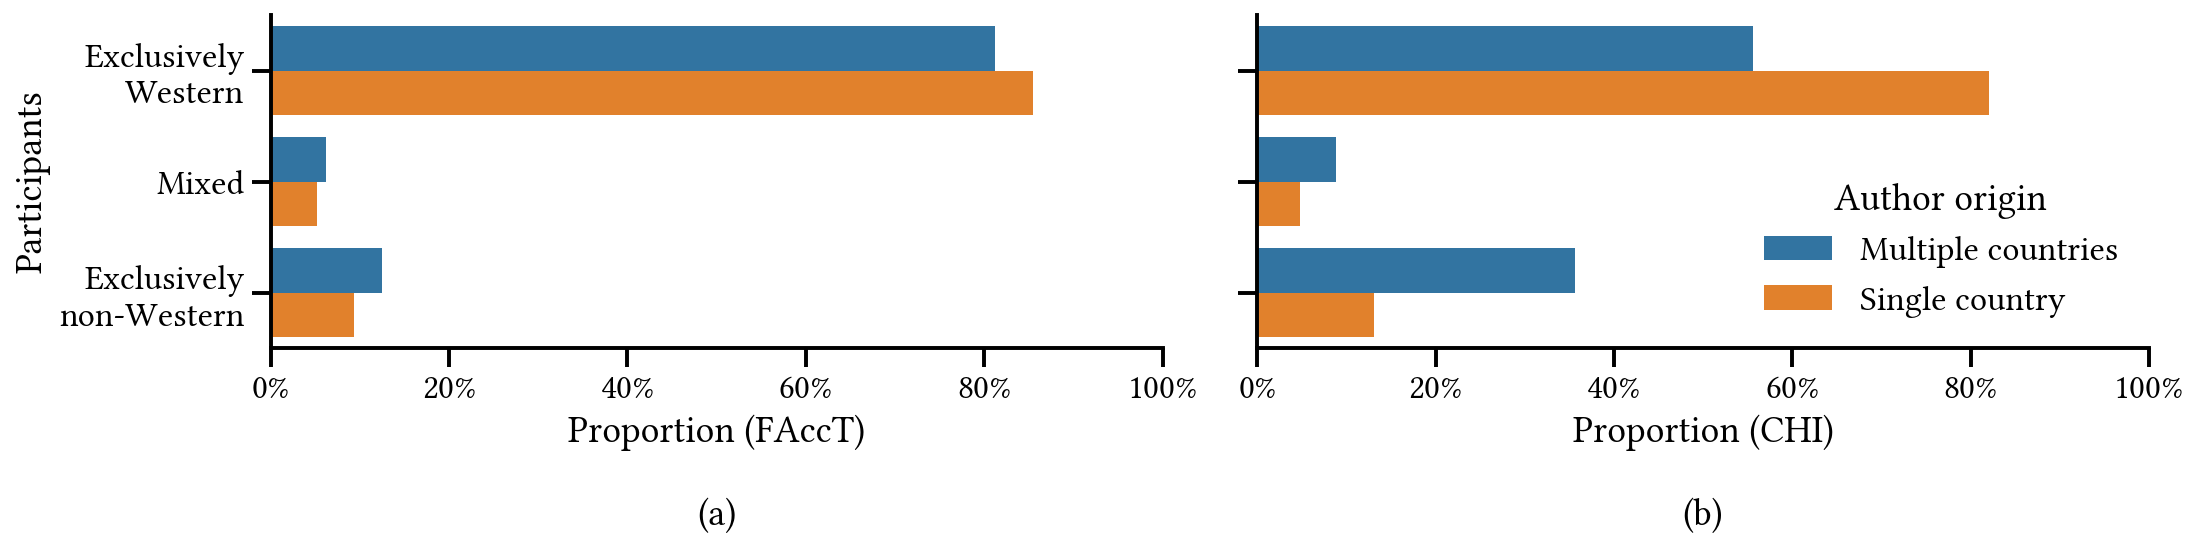

In [148]:
# Generating Figure 6
import matplotlib.ticker as mtick

sns.set_context('talk')
fig, ax = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)
sns.barplot(
    x='pct',
    hue='author origin',
    y='western',
    data=pd.DataFrame(
        [
            ['Multiple countries', 'Exclusively\nWestern', 0.8125],
            ['Multiple countries', 'Mixed', 0.0625],
            ['Multiple countries', 'Exclusively\nnon-Western', 0.1250],
            ['Single country', 'Exclusively\nWestern', 0.8542],
            ['Single country', 'Mixed', 0.0521],
            ['Single country', 'Exclusively\nnon-Western', 0.0937],
        ],
        columns=['author origin', 'western', 'pct']
    ).assign(pct=lambda x: x.pct * 100),
    palette=sns.color_palette('tab10', 2),
    ax=ax[0]
)

sns.barplot(
    x='pct',
    hue='Author origin',
    y='western',
    data=pd.DataFrame(
        [
            ['Multiple countries', 'Exclusively\nWestern', 0.556],
            ['Multiple countries', 'Mixed', 0.088],
            ['Multiple countries', 'Exclusively\nnon-Western', 0.356],
            ['Single country', 'Exclusively\nWestern', 0.8208],
            ['Single country', 'Mixed', 0.0484],
            ['Single country', 'Exclusively\nnon-Western', 0.1308],
        ],
        columns=['Author origin', 'western', 'pct']
    ).assign(pct=lambda x: x.pct * 100),
    palette=sns.color_palette('tab10', 2),
    ax=ax[1]
)

ax[0].legend_.remove()
ax[1].legend(loc='lower right', title='Author origin', frameon=False)
ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].set_xlabel('Proportion (FAccT)\n\n(a)')
ax[1].set_xlabel('Proportion (CHI)\n\n(b)')
ax[0].set_ylabel('Participants')
ax[1].set_ylabel('')
plt.tight_layout()
plt.savefig('figures/western.pdf', bbox_inches='tight')

## Dataset World Map

In [149]:
data.groupby('paper_id').original.mean().value_counts(True)

0.000000    0.703125
1.000000    0.273438
0.500000    0.007812
0.333333    0.007812
0.750000    0.007812
Name: original, dtype: float64

In [150]:
original_ids = data.query('original').paper_id.unique()

cs = facct_countries.query('paper_id not in @original_ids').dropna().groupby('paper_id').country.unique()
pairs = []
for index, values in cs.items():
    for val in values:
        pairs.append([index, val])

author_sample = data.merge(
    pd.DataFrame(pairs, columns=['paper_id', 'author_country']),
    how='left',
    on='paper_id'
).groupby(['author_country', 'country']).agg({
    'paper_id': 'size',
    'nb_records': 'sum'
}).reset_index()
author_sample = author_sample.rename({'paper_id': 'nb_papers', 'nb_records': 'nb_participants'}, axis=1)

In [151]:
author_sample.sort_values(['author_country', 'nb_participants']).groupby('author_country').tail(1)

,author_country,country,nb_papers,nb_participants
0,AUS,USA,1,350086.0
1,BRA,USA,1,10000.0
2,CAN,USA,11,287551.0
4,CHE,USA,6,65751.0
9,DEU,USA,13,1856234.0
10,FRA,USA,2,13011.0
14,GBR,USA,8,1482594.0
17,IND,USA,3,3979181.0
23,ITA,USA,5,63270.0
25,JPN,USA,1,6040.0


In [152]:
world['centre'] = world.centroid

/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_8617/903306647.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centre'] = world.centroid


In [153]:
cblind = ListedColormap(sns.color_palette(['#FFFFFF', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']).as_hex())

In [154]:
dataset_countries = set()
for _, group in data.groupby('original'):
    cs = facct_countries[facct_countries.paper_id.isin(group.paper_id.unique())].dropna().groupby('paper_id').country.unique()
    pairs = []
    for index, values in cs.items():
        for val in values:
            pairs.append([index, val])

    author_sample = data.merge(
        pd.DataFrame(pairs, columns=['paper_id', 'author_country']),
        how='left',
        on='paper_id'
    ).groupby(['author_country', 'country']).agg({
        'paper_id': 'size',
        'nb_records': 'sum'
    }).reset_index()
    author_sample = author_sample.rename({'paper_id': 'nb_papers', 'nb_records': 'nb_participants'}, axis=1)
    dataset_countries = dataset_countries.union(
        set(author_sample.sort_values(['author_country', 'nb_papers', 'nb_participants']).groupby('author_country').tail(1).country)
    )

In [155]:
colormap = dict(zip(dataset_countries, ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']))

In [156]:
to_map = author_sample.sort_values(['author_country', 'nb_papers', 'nb_participants']).groupby('author_country').tail(1)[['author_country', 'country']].set_index('author_country').country.to_dict()
country_names = world.set_index('iso_a3').name.to_dict()
country_names['USA'] = 'USA'

In [157]:
colormap = {'USA': '#d73027','KOR': '#cc79a7','GBR': '#56B4E9','DEU': '#00678a','IND': '#a3cce9','NLD': '#f5ab65','COL': '#F0E442'}

In [158]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

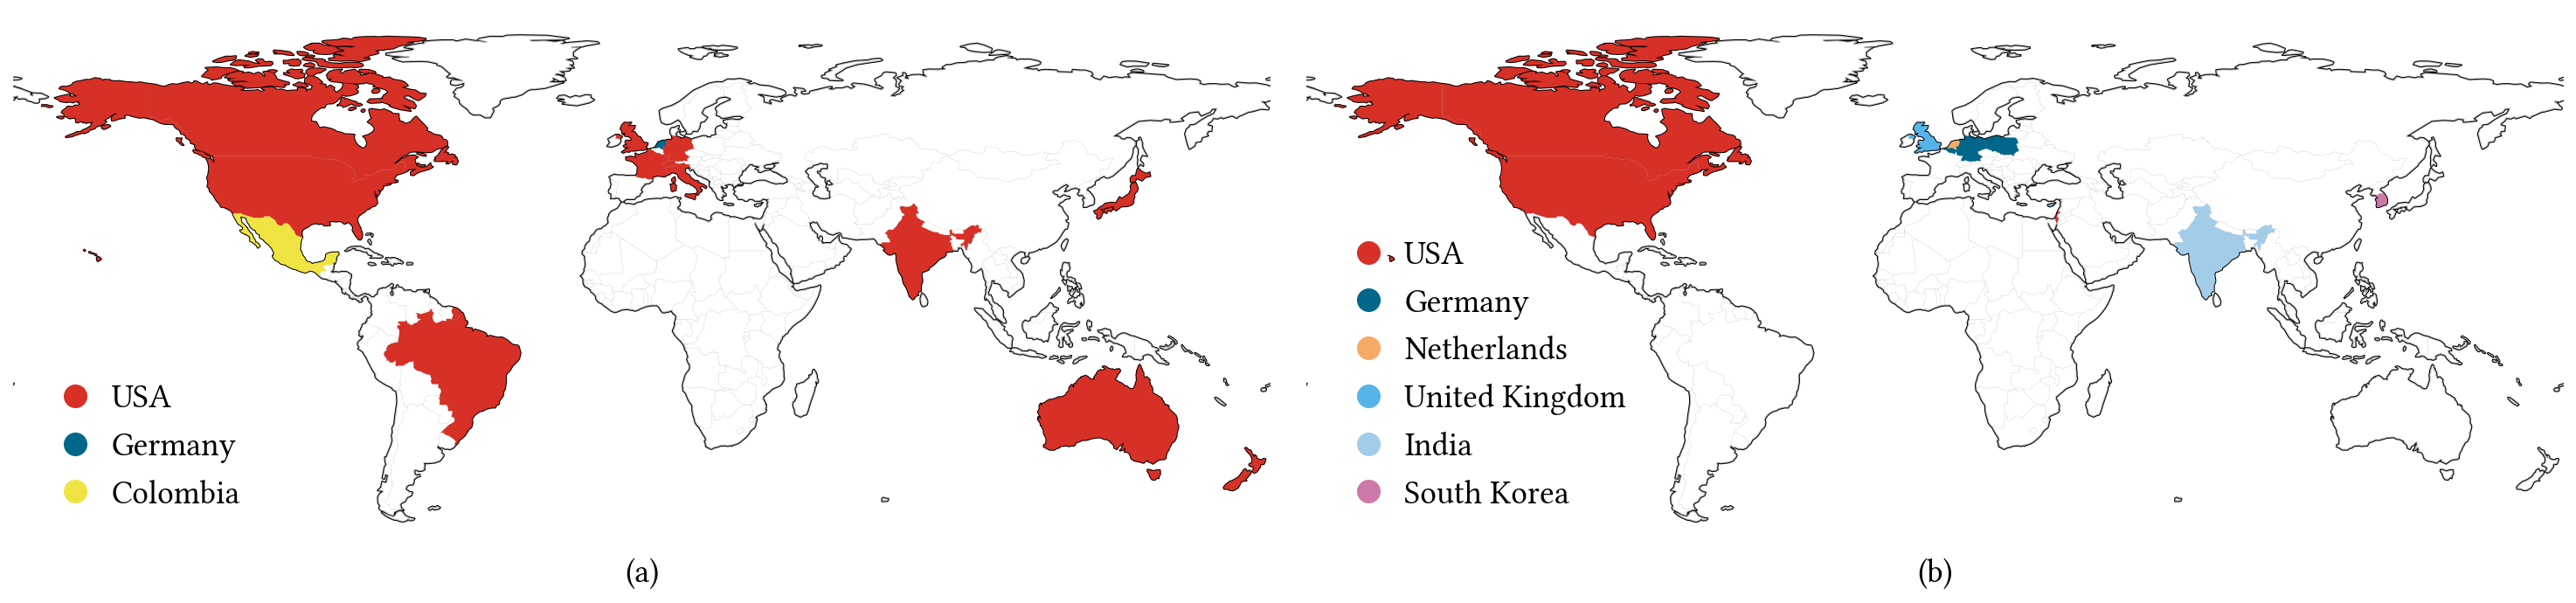

In [160]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)

fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
for ax, (_, group) in zip((ax1, ax2), data.groupby('original')):
    cs = facct_countries[facct_countries.paper_id.isin(group.paper_id.unique())].dropna().groupby('paper_id').country.unique()
    pairs = []
    for index, values in cs.items():
        for val in values:
            pairs.append([index, val])

    author_sample = data.merge(
        pd.DataFrame(pairs, columns=['paper_id', 'author_country']),
        how='left',
        on='paper_id'
    ).groupby(['author_country', 'country']).agg({
        'paper_id': 'size',
        'nb_records': 'sum'
    }).reset_index()
    author_sample = author_sample.rename({'paper_id': 'nb_papers', 'nb_records': 'nb_participants'}, axis=1)
    top_countries = author_sample.sort_values(['author_country', 'nb_papers', 'nb_participants']).groupby('author_country').tail(1)
    to_map = top_countries.set_index('author_country').country.to_dict()

    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=0.1)
    ax.set_extent([-150, 60, -25, 90])
    ax.axis('off')

    countries = reader.records()
    author_sample.sort_values(['author_country', 'nb_papers', 'nb_participants']).groupby('author_country').tail(1).author_country

    for country in countries:
        if country.attributes['ADM0_A3'] in to_map.keys():
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor=colormap[to_map[country.attributes['ADM0_A3']]],
                            label=country.attributes['ADM0_A3'])
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor='#FFFFFF', alpha=0.7,
                            label=country.attributes['ADM0_A3'])

patches = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap[key], label=country_names[key], markersize=14) for key in ['USA', 'DEU', 'COL']]
ax1.legend(handles=patches, loc='lower left', frameon=False, fontsize=18, handletextpad=0.1)
patches = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap[key], label=country_names[key], markersize=14) for key in ['USA', 'DEU', 'NLD', 'GBR', 'IND', 'KOR']]
ax2.legend(handles=patches, loc='lower left', frameon=False, fontsize=18, handletextpad=0.1)
ax1.set_title('(a)', y=-0.1)
ax2.set_title('(b)', y=-0.1)
plt.tight_layout()
plt.savefig('figures/world-map-datasets.pdf', bbox_inches='tight', facecolor='w', pad_inches=0)

In [161]:
pd.merge(
    author_sample.sort_values(['author_country', 'nb_papers', 'nb_participants']).groupby('author_country').tail(1),
    world[['iso_a3', 'name']],
    how='left',
    left_on='country',
    right_on='iso_a3'
)

,author_country,country,nb_papers,nb_participants,iso_a3,name
0,BEL,DEU,2,14.0,DEU,Germany
1,CAN,USA,4,2153.0,USA,United States of America
2,CYP,GBR,1,40.0,GBR,United Kingdom
3,DEU,DEU,4,382.0,DEU,Germany
4,GBR,GBR,4,422.0,GBR,United Kingdom
5,IND,IND,3,14487.0,IND,India
6,ISR,USA,1,49.0,USA,United States of America
7,KOR,KOR,1,9.0,KOR,South Korea
8,NLD,NLD,1,75.0,NLD,Netherlands
9,POL,DEU,2,14.0,DEU,Germany


In [162]:
cs = chi_affil.groupby('paper_id').country.unique()
pairs = []
for index, values in cs.items():
    for val in values:
        pairs.append([index, val])

author_sample = c.merge(
    pd.DataFrame(pairs, columns=['paper_id', 'author_country']),
    how='left',
    on='paper_id'
).groupby(['author_country', 'country']).agg({
    'paper_id': 'size',
    'nb_participants': 'sum'
}).reset_index()
author_sample = author_sample.rename({'paper_id': 'nb_papers'}, axis=1)

In [163]:
plt.rcParams['font.size'] = 8

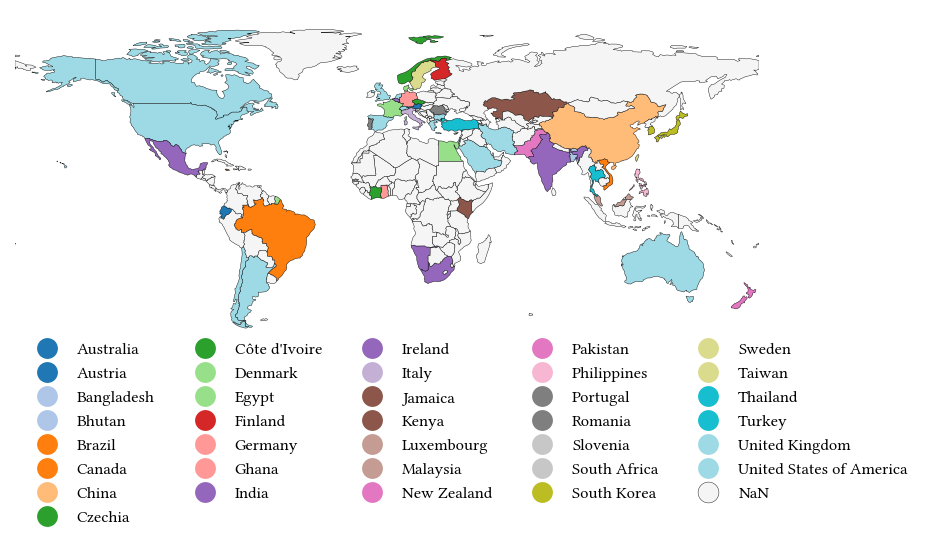

In [164]:
fig, ax = plt.subplots()
world.query('continent != "Antarctica"').merge(
    pd.merge(
        author_sample.sort_values(['author_country', 'nb_participants']).groupby('author_country').tail(1),
        world[['iso_a3', 'name']],
        how='left',
        left_on='country',
        right_on='iso_a3'
    ),
    how='left',
    left_on='iso_a3',
    right_on='author_country',
    suffixes=('', '_sample')
).plot(
    column='name_sample', edgecolor='black',
    linewidth=0.2, figsize=(12, 7),
    legend=True,
    missing_kwds=dict(
        color='#f5f5f5',
    ),
    legend_kwds=dict(
        # title='Origin of most used datasets',
        loc='lower left',
        frameon=False,
        fontsize=8,
        ncol=5,
        bbox_to_anchor=(0, -0.6)
    ),
    cmap='tab20',
    ax=ax
)
ax.set_xlim(-180, 180)
ax.axis('off');

In [165]:
cs = facct_countries.query('paper_id not in @original_ids').dropna().groupby('paper_id').country.unique()
pairs = []
for index, values in cs.items():
    for val in values:
        pairs.append([index, val])

author_sample = data.merge(
    pd.DataFrame(pairs, columns=['paper_id', 'author_country']),
    how='left',
    on='paper_id'
).groupby(['author_country', 'country']).agg({
    'paper_id': 'size',
    'nb_records': 'sum'
}).reset_index()
author_sample = author_sample.rename({'paper_id': 'nb_papers', 'nb_records': 'nb_participants'}, axis=1)

### Sample Size (Law of Large Numbers)

In [333]:
sns.set_context('talk')

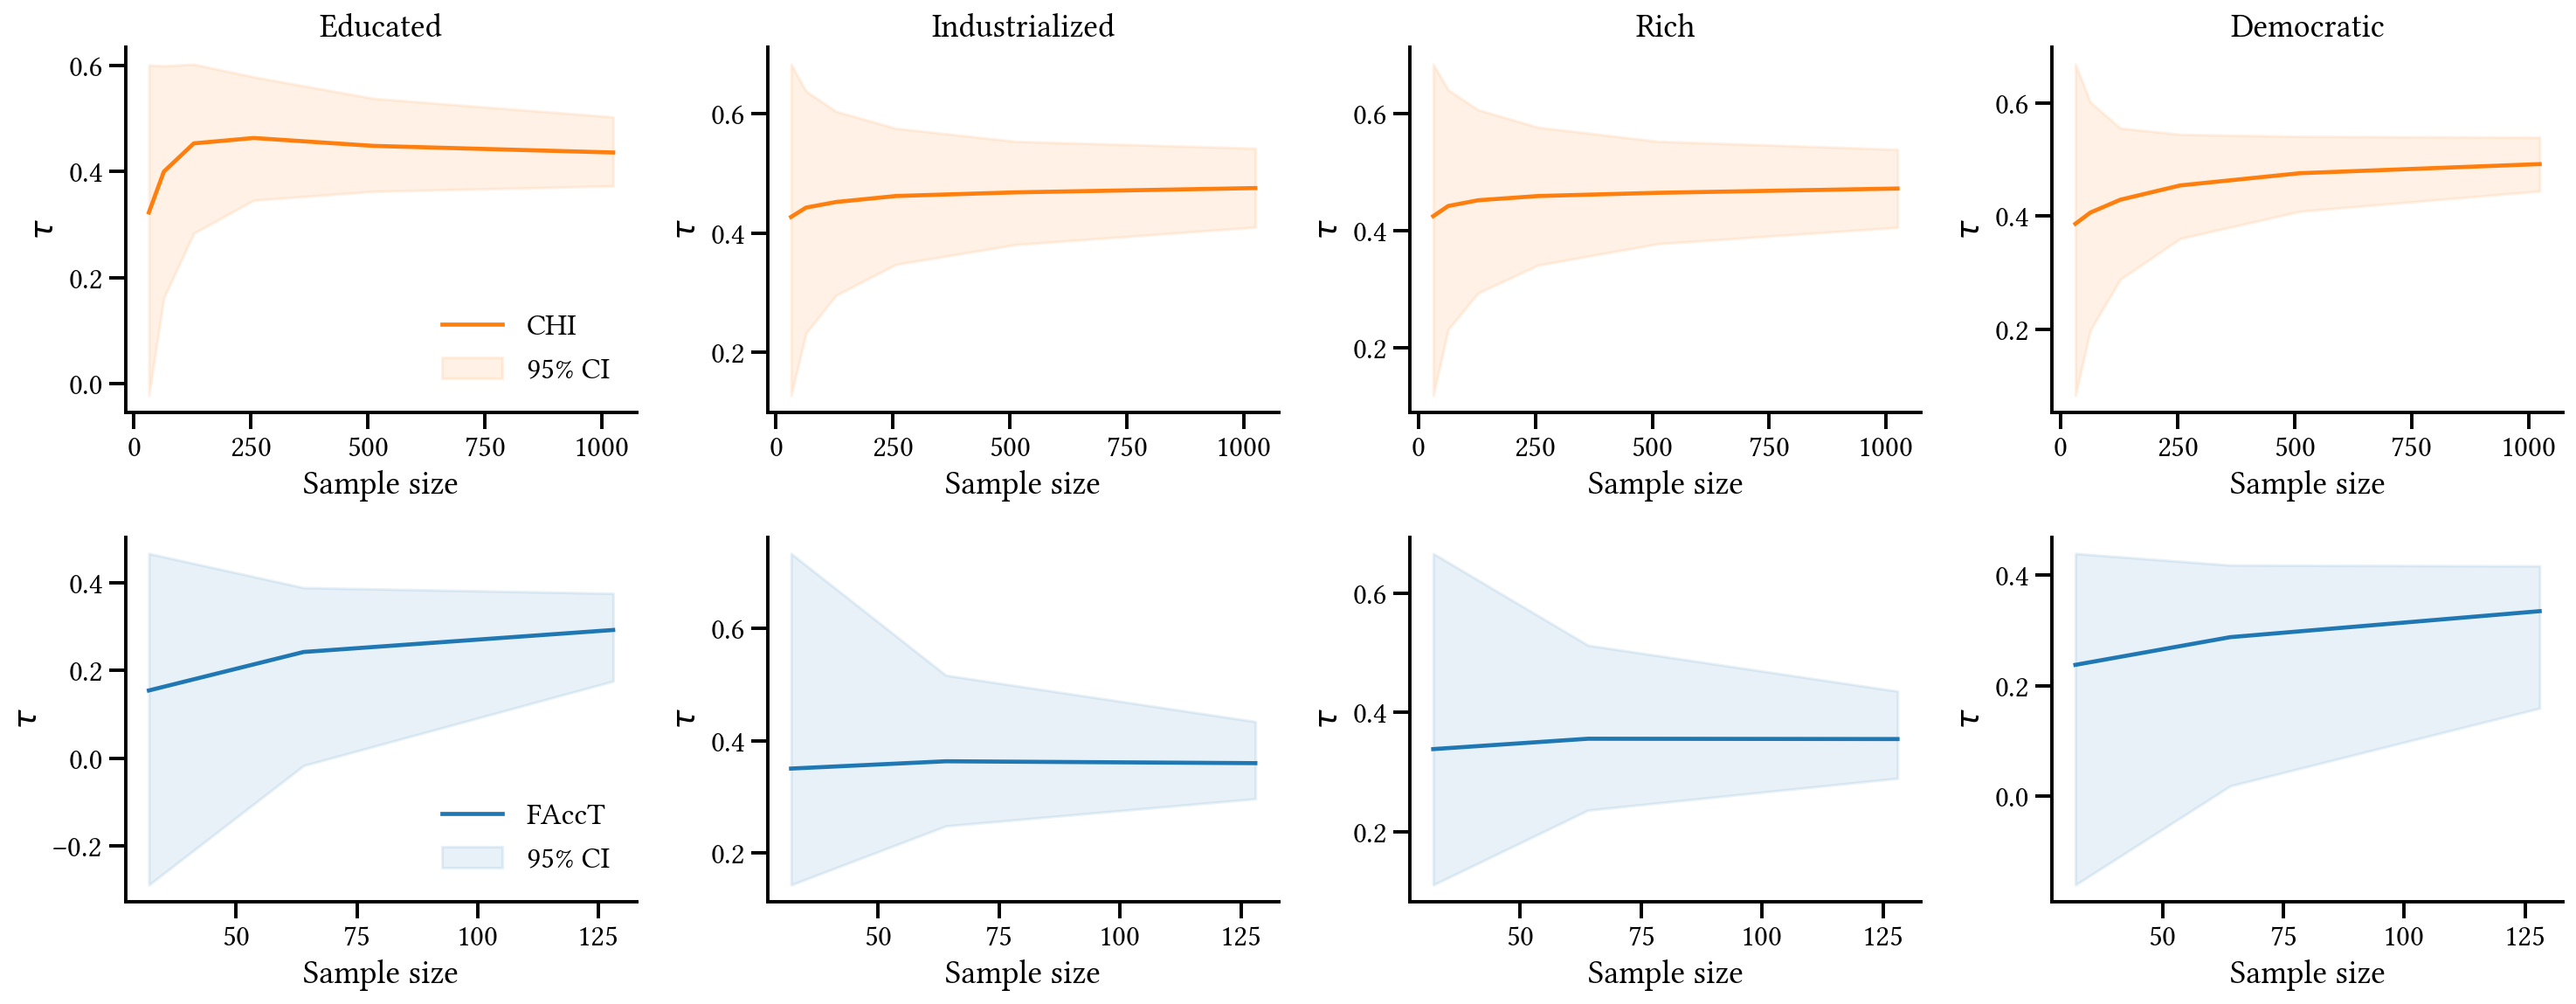

In [362]:
# Generating Figure 3
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=4)

for i, (ax, col, label) in enumerate(zip(
    axes.T,
    ['mean_edu', 'gdp', 'gni', 'political rights'],
    ['Educated', 'Industrialized', 'Rich', 'Democratic']
)):
    # CHI
    ns = np.power(2, np.arange(5, 11))
    tau_samples = []
    for sample_size in ns:
        tt = []
        for _ in range(10_000):
            c_sample = c[c['new_id'].isin(np.random.choice(np.arange(1076), replace=True, size=sample_size))]
            chi_sample_stats = get_stats(c_sample)
            tt.append(
                compute_metric(chi_sample_stats, col, 'psi_s', is_print=False)[0]
            )
        tau_samples.append(tt)
    tau_samples = np.array(tau_samples)

    means = tau_samples.mean(axis=1)
    bounds = np.quantile(tau_samples, [0.025, 0.975], axis=1)

    ax[0].plot(ns, tau_samples.mean(axis=1), color='C1')
    ax[0].fill_between(ns, *bounds, alpha=.1, color='C1')
    ax[0].set_title(label)
    ax[0].set_xlabel('Sample size')
    ax[0].set_ylabel('$\\tau$')
    if i == 0:
        ax[0].legend(['CHI', '95% CI'], frameon=False, loc='lower right')

    # FAccT
    ns = np.power(2, np.arange(4, 8))
    tau_samples = []
    for sample_size in ns:
        tt = []
        for _ in range(10_000):
            data_sample = data[data['paper_id'].isin(np.random.choice(data.paper_id.unique(), replace=True, size=sample_size))]
            facct_sample_stats = get_stats(data_sample)
            tt.append(
                compute_metric(facct_sample_stats, col, 'psi_s', is_print=False)[0]
            )
        tau_samples.append(tt)
    tau_samples = np.array(tau_samples)

    means = tau_samples.mean(axis=1)
    bounds = np.quantile(tau_samples, [0.025, 0.975], axis=1)

    ax[1].plot(ns, tau_samples.mean(axis=1), color='C0')
    ax[1].fill_between(ns, *bounds, alpha=.1, color='C0')
    ax[1].set_xlabel('Sample size')
    ax[1].set_ylabel('$\\tau$')
    if i == 0:
        ax[1].legend(['FAccT', '95% CI'], frameon=False, loc='lower right')
plt.tight_layout()
plt.savefig('../figures/sample_size_bootstrapped.pdf', bbox_inches='tight', facecolor='w')

### Off-the-shelf vs Original

In [168]:
data.groupby('paper_id').original.mean().value_counts()

0.000000    90
1.000000    35
0.500000     1
0.333333     1
0.750000     1
Name: original, dtype: int64

In [169]:
mixed_ids = data.groupby('paper_id').original.mean()[~data.groupby('paper_id').original.mean().isin([0, 1])].index

In [170]:
ori_west = combine(data).query('paper_id not in @mixed_ids').groupby('paper_id').agg({
    'original': 'mean',
    'west': 'mean'
})
ori_west[~ori_west.isin([0, 1])] = 0.5
contingency = ori_west.reset_index().pivot_table(
    index='west',
    columns='original',
    values='paper_id',
    aggfunc='count'
)

In [171]:
data['is_usa'] = data['country'].eq('USA')
data.query('original').groupby('paper_id').is_usa.mean().value_counts(True)

1.000000    0.552632
0.000000    0.342105
0.500000    0.052632
0.076923    0.026316
0.333333    0.026316
Name: is_usa, dtype: float64

In [181]:
contingency / contingency.values.sum(axis=0)

original,0.0,1.0
west,,
0.0,0.044444,0.142857
0.5,0.077778,0.114286
1.0,0.877778,0.742857


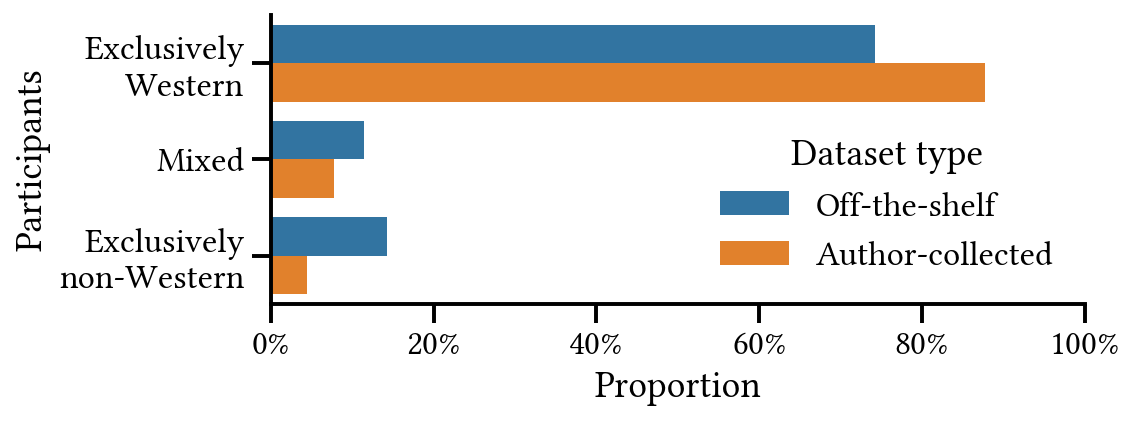

In [176]:
# Generating Figure 4
fig, ax = plt.subplots(figsize=(7, 2.5))
sns.barplot(
    x='pct',
    hue='dataset type',
    y='western',
    data=pd.DataFrame(
        [
            ['Off-the-shelf', 'Exclusively\nWestern', 0.743],
            ['Off-the-shelf', 'Mixed', 0.114],
            ['Off-the-shelf', 'Exclusively\nnon-Western', 0.143],
            ['Author-collected', 'Exclusively\nWestern', 0.878],
            ['Author-collected', 'Mixed', 0.078],
            ['Author-collected', 'Exclusively\nnon-Western', 0.044],
        ],
        columns=['dataset type', 'western', 'pct']
    ).assign(pct=lambda x: x.pct * 100),
    palette=sns.color_palette('tab10', 2),
    ax=ax
)
ax.legend(loc='lower right', title='Dataset type', frameon=False)
ax.set_xlim(0, 100)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Proportion')
ax.set_ylabel('Participants')
# ax.set_yticklabels(['Exclusively\nnon-Western', 'Mixed', 'Exclusively\nWestern'])
plt.savefig('figures/western-origin.pdf', bbox_inches='tight')

In [155]:
from scipy.stats import chi2_contingency

ori = data.groupby('paper_id').agg({
    'original': 'max',
    'country': pd.Series.nunique
})
ori['country'] = ori['country'].gt(1)
ori = ori.reset_index().pivot_table(
    index='original',
    columns='country',
    values='paper_id',
    aggfunc='size'
)
print(ori)
chi2_contingency(ori.values)

country   False  True 
original              
False        66     24
True         31      7


(0.5915118135656179,
 0.4418351045451757,
 1,
 array([[68.203125, 21.796875],
        [28.796875,  9.203125]]))

In [182]:
nb_original = data.query('original').paper_id.nunique()
nb_non_ori = data.query('~original').paper_id.nunique()
nb_original, nb_non_ori

(38, 93)

In [183]:
paper_ids = data['paper_id'].unique()

In [ ]:
# Generating Table 6
np.random.seed(42)

for col in [
    'mean_edu',
    'gdp',
    'gni',
    'political rights'
]:
    tau_diff = []
    for _ in range(10_000):
        ori_ids = np.random.choice(paper_ids, nb_original)

        tau_ori = compute_metric(get_stats(data.query('paper_id in @ori_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_non_ori = compute_metric(get_stats(data.query('paper_id not in @ori_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_diff.append(tau_ori - tau_non_ori)

    tau_ori = compute_metric(get_stats(data.query('original')), col, 'psi_s', bootstrap=False, is_print=False)[0]
    tau_non_ori = compute_metric(get_stats(data.query('~original')), col, 'psi_s', bootstrap=False, is_print=False)[0]

    delta_tau = tau_ori - tau_non_ori
    tau_diff = np.array(tau_diff)
    pval = (tau_diff >= tau_ori - tau_non_ori).mean()
    print(f"{col}, {delta_tau:.4f}, [{np.quantile(tau_diff, 0.025):.4f}, {np.quantile(tau_diff, 0.975):.4f}], pval={pval:.4f}")

```latex
mean_edu, -0.0308, [-0.5235, 0.1539], pval=0.2993
gdp, 0.0855, [-0.1987, 0.2633], pval=0.1409
gni, 0.0639, [-0.2114, 0.2755], pval=0.2029
political rights, 0.0185, [-0.5118, 0.1830], pval=0.2958
```

### Western

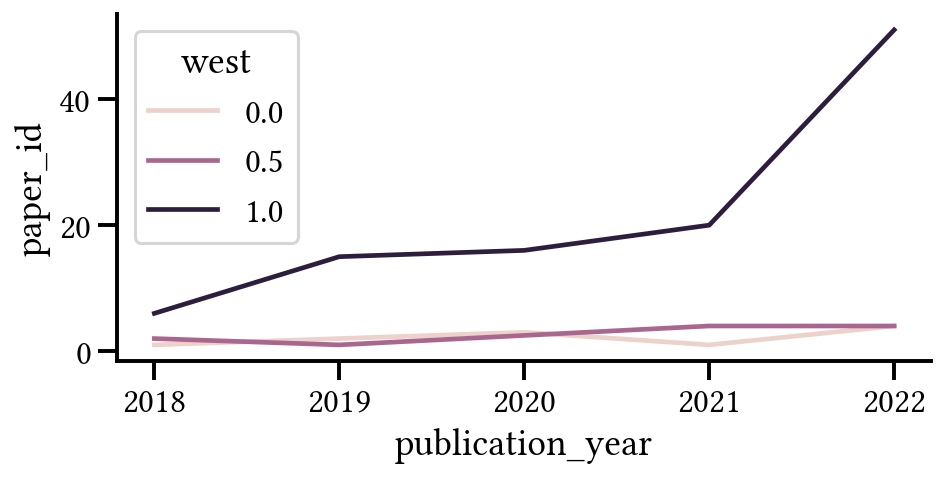

In [184]:
facct_west_per_year = combine(data).groupby(['publication_year', 'paper_id']).agg({
    'west': 'mean'
}).reset_index()
facct_west_per_year['west'] = facct_west_per_year['west'].apply(lambda x: x if x in (0, 1) else 0.5)

fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(
    x='publication_year',
    y='paper_id',
    hue='west',
    data=facct_west_per_year.groupby(['publication_year', 'west']).agg({
        'paper_id': 'size'
    }).reset_index()
)
# plt.legend(['exclusively non-western', 'mixed', 'exclusively western'])
plt.xticks(np.arange(2018, 2023));

In [189]:
# FAccT
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
combine(data).groupby('paper_id').west.mean().value_counts(True)

1.000000    0.843750
0.000000    0.070312
0.500000    0.054688
0.769231    0.007812
0.527778    0.007812
0.666667    0.007812
0.750000    0.007812
Name: west, dtype: float64

In [190]:
# CHI
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
cc = pd.merge(
    chi,
    western,
    how='left',
    left_on='country_code',
    right_on='country'
)
cc.groupby('paper_id').west.mean().value_counts(True).head()

1.000000    0.759294
0.000000    0.183086
0.500000    0.021375
0.666667    0.006506
0.750000    0.003717
Name: west, dtype: float64

### Same Set of Countries

In [279]:
# Generating Table 5
country_intersection = set(data['country']).intersection(set(c['country']))
taus = []
facct_intersection = get_stats(data[data.country.isin(country_intersection)])
chi_intersection = get_stats(c[c.country.isin(country_intersection)])
for col in ['mean_edu', 'gdp', 'gni', 'political rights']:
    tau_facct = compute_metric(facct_intersection, col, 'psi_s', is_print=False)[0]
    compute_metric(facct_intersection, col, 'psi_s', bootstrap=True)
    tau_chi = compute_metric(chi_intersection, col, 'psi_s', is_print=False)[0]
    compute_metric(chi_intersection, col, 'psi_s', bootstrap=True)
    taus.append({
        'variable': col,
        'facct': tau_facct,
        'chi': tau_chi
    })

0.40;[0.178, 0.619]
0.54;[0.369, 0.715]
0.44;[0.274, 0.604]
0.65;[0.552, 0.748]
0.44;[0.271, 0.603]
0.65;[0.548, 0.746]
0.45;[0.270, 0.630]
0.58;[0.401, 0.763]


In [244]:
pd.DataFrame(taus)

,variable,facct,chi
0,mean_edu,0.396970,0.541747
1,gdp,0.440186,0.649245
2,gni,0.437863,0.646922
3,political rights,0.449350,0.582222


### Comparing EIRD for both conferences

In [82]:
taus = []
for _ in range(10_000):
    tau = compute_metric(
        get_stats(data[data['paper_id'].isin(np.random.choice(data.paper_id.unique(), data.paper_id.nunique()))]),
        'mean_edu',
        'psi_s',
        is_print=False
    )[0]
    taus.append(tau)

### Educated

In [256]:
compute_metric(chi_stats, 'mean_edu', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'mean_edu', 'psi_s', bootstrap=False)

0.43;[0.292, 0.562]
tau = 0.43, p-val = 0.0000


In [257]:
compute_metric(stats, 'mean_edu', 'psi_s', bootstrap=True)
compute_metric(stats, 'mean_edu', 'psi_s', bootstrap=False)

0.31;[0.118, 0.503]
tau = 0.31, p-val = 0.0018


### Industrialized

In [263]:
compute_metric(chi_stats, 'gdp', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'gdp', 'psi_s', bootstrap=False)

0.52;[0.392, 0.641]
tau = 0.52, p-val = 0.0000


In [264]:
compute_metric(stats, 'gdp', 'psi_s', bootstrap=True)
compute_metric(stats, 'gdp', 'psi_s', bootstrap=False)

0.35;[0.207, 0.502]
tau = 0.36, p-val = 0.0003


### Rich

In [268]:
compute_metric(chi_stats, 'gni', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'gni', 'psi_s', bootstrap=False)

0.52;[0.397, 0.639]
tau = 0.52, p-val = 0.0000


In [269]:
compute_metric(stats, 'gni', 'psi_s', bootstrap=True)
compute_metric(stats, 'gni', 'psi_s', bootstrap=False)

0.35;[0.201, 0.499]
tau = 0.35, p-val = 0.0004


### Democratic

In [282]:
compute_metric(chi_stats, 'political rights', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'political rights', 'psi_s', bootstrap=False)

0.49;[0.377, 0.600]
tau = 0.49, p-val = 0.0000


In [283]:
compute_metric(stats, 'political rights', 'psi_s', bootstrap=True)
compute_metric(stats, 'political rights', 'psi_s', bootstrap=False)

0.36;[0.185, 0.538]
tau = 0.36, p-val = 0.0004


# Supplementary

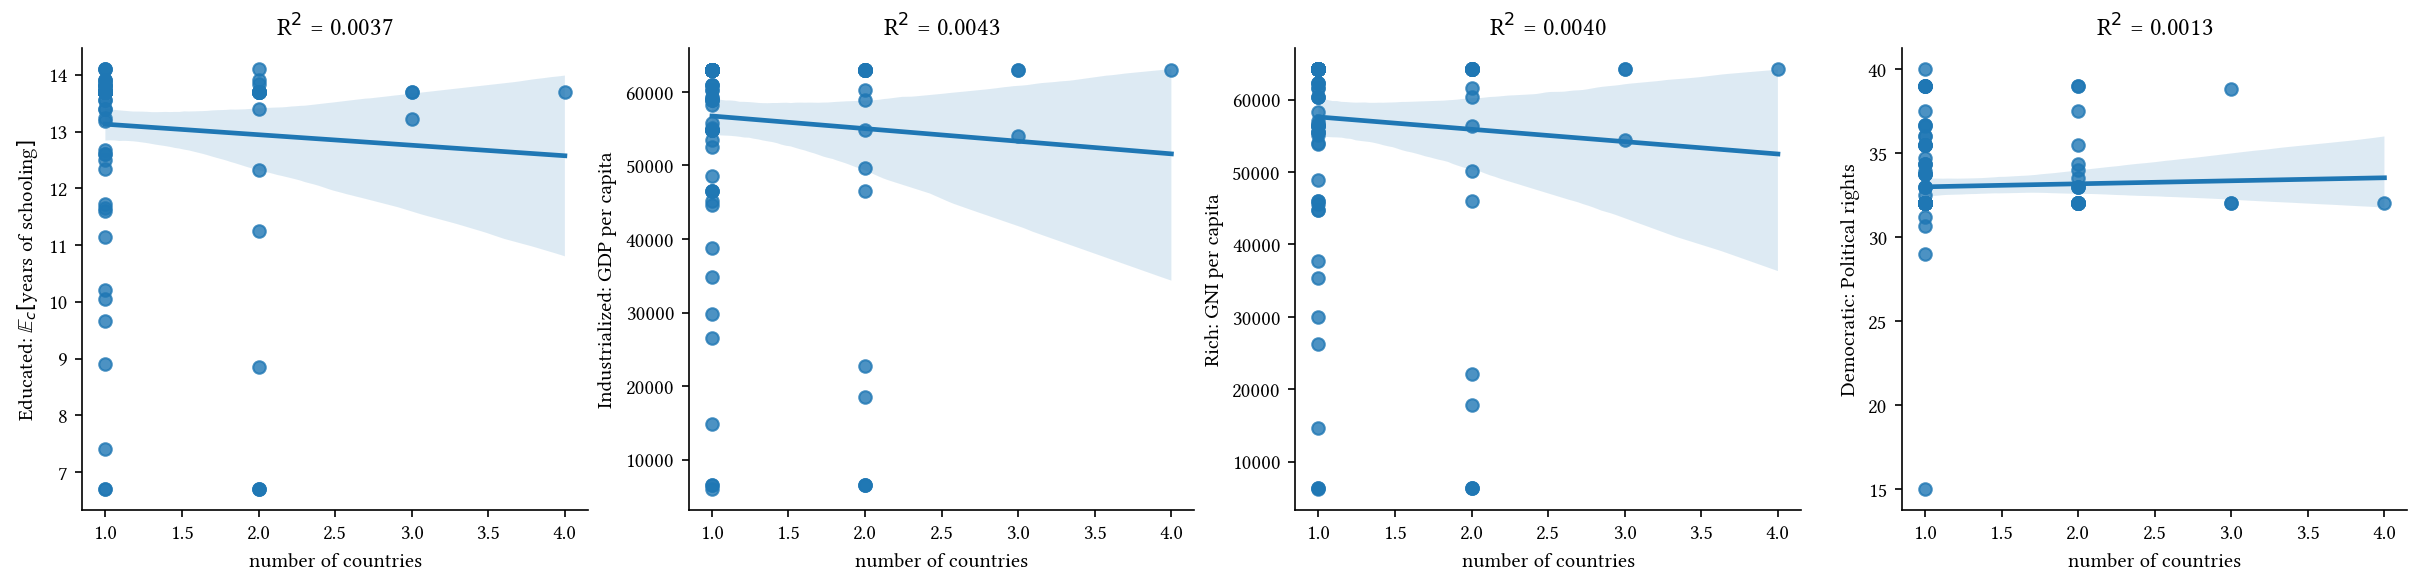

In [ ]:
import statsmodels.formula.api as smf

bootstrapped_facct = aff_facct.sample(1000, replace=True)

fig, axes = plt.subplots(figsize=(20, 4), ncols=4)
mdls = []
for ax, col, label in zip(
    axes.flatten(),
    ['mean_edu', 'gdp', 'gni', 'pol_rights'],
    ['Educated: $\mathbb{E}_c[$years of schooling$]$', 'Industrialized: GDP per capita', 'Rich: GNI per capita', 'Democratic: Political rights']
):
    sns.regplot(
        x='nb_countries',
        y=col,
        data=aff_facct,
        ax=ax,
    )
    ax.set_xlabel('number of countries')
    ax.set_ylabel(label)
    mdl = smf.ols(f"{col} ~ nb_countries", data=aff_facct).fit()
    ax.set_title(f"R$^2$ = {mdl.rsquared:.4f}")
    mdls.append({
        'dep_variable': label.split(':')[0],
        'coef': mdl.params[1],
        'lb': mdl.params[1] - 1.96 * mdl.bse['nb_countries'],
        'ub': mdl.params[1] + 1.96 * mdl.bse['nb_countries'],
        'pval': mdl.pvalues[1]
    })
plt.savefig('figures/nb_affiliates.pdf', bbox_inches='tight', facecolor='w')

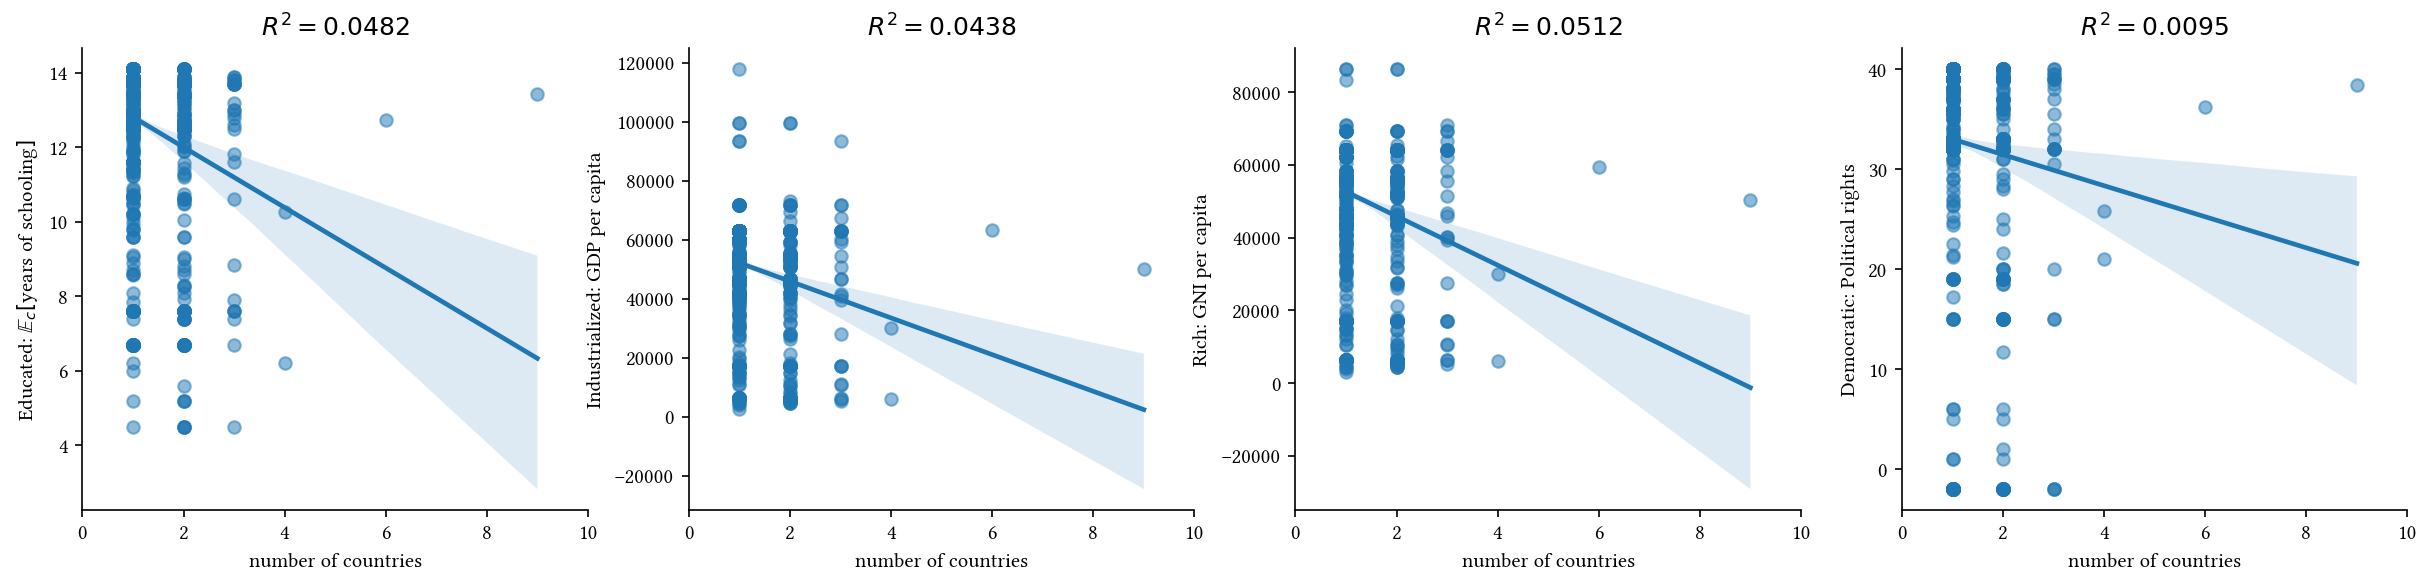

In [ ]:
fig, axes = plt.subplots(figsize=(20, 4), ncols=4)
mdls = []
for ax, col, label in zip(
    axes.flatten(),
    ['mean_edu', 'gdp', 'gni', 'pol_rights'],
    ['Educated: $\mathbb{E}_c[$years of schooling$]$', 'Industrialized: GDP per capita', 'Rich: GNI per capita', 'Democratic: Political rights']
):
    sns.regplot(
        x='nb_countries',
        y=col,
        data=aff_chi,
        scatter_kws=dict(
            alpha=.5
        ),
        ax=ax
    )
    ax.set_xlim(0, 10)
    ax.set_xlabel('number of countries')
    ax.set_ylabel(label)
    mdl = smf.ols(f"{col} ~ nb_countries", data=aff_chi).fit()
    ax.set_title(f"$R^2 = {mdl.rsquared:.4f}$")
    mdls.append({
        'dep_variable': label.split(':')[0],
        'coef': mdl.params[1],
        'pval': mdl.pvalues[1]
    })
plt.savefig('figures/nb_countries_chi.png', bbox_inches='tight', facecolor='w')